In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from PIL import Image

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers  import Dense, Dropout, Flatten, Conv2D,MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.python.keras import utils
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

np.random.seed(42)

%matplotlib inline

In [6]:
# First 5 images from Normal class
!ls ../input/chest_xray/chest_xray/train/NORMAL/* | head

../input/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0117-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0119-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0122-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0125-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0127-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0128-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0129-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0131-0001.jpeg
../input/chest_xray/chest_xray/train/NORMAL/IM-0133-0001.jpeg


Normal
Size of image:(1468, 993)


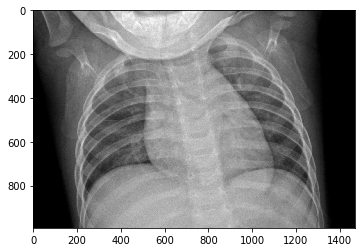

(1468, 993)

In [7]:
image_ex = load_img("../input/chest_xray/chest_xray/train/NORMAL/IM-0133-0001.jpeg")

print("Normal")
plt.imshow(image_ex)
print(f"Size of image:{image_ex.size}")
plt.show()
image_ex.size

# will need to do shear

In [8]:
!ls ../input/chest_xray/chest_xray/train/PNEUMONIA/* | head

/bin/sh: /bin/ls: Argument list too long


Pneumonia
Size of image:(1244, 863)


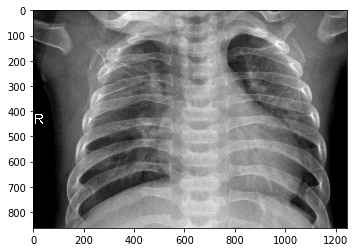

In [9]:
image_ex = load_img("../input/chest_xray/chest_xray/train/PNEUMONIA/person1001_bacteria_2932.jpeg")

print("Pneumonia")
print(f"Size of image:{image_ex.size}")
plt.imshow(image_ex)
plt.show()

In [10]:
# directory paths
train_dir = "../input/chest_xray/chest_xray/train"
val_dir = "../input/chest_xray/chest_xray/val"
test_dir = "../input/chest_xray/chest_xray/test"

In [8]:
# InceptionV3 model
import tensorflow
from tensorflow.keras.applications.inception_v3 import InceptionV3

model = Sequential()

model.add(InceptionV3(include_top = False,
                      weights = 'imagenet',
                      input_shape=(150,150,3)))

# Dropout
model.add(Dropout(0.5))

# Pooling layer
model.add(GlobalAveragePooling2D())

# Dense layer
model.add(Dense(128, 
                activation = "relu"))

# Batch Normalizer
model.add(BatchNormalization())

# Output layer
model.add(Dense(2,
                activation = "softmax"))

In [9]:
# check
model.input, model.output

(<tf.Tensor 'inception_v3_input:0' shape=(None, 150, 150, 3) dtype=float32>,
 <tf.Tensor 'dense_1/Identity:0' shape=(None, 2) dtype=float32>)

In [10]:
# Early Stopping
early_stop = EarlyStopping(monitor = "val_loss",
                           min_delta = 0,
                           patience = 3)
# Multiplies the learning rate by factor of 0.1 when the monitored metric (val_acc) plateaus 
# this will prevent overshooting -- since plateau means getting close to local minimum (lowest val loss)
#lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

# Compile model
model.compile(loss = "binary_crossentropy",
              optimizer = Adam(lr = 0.0001),
              metrics = ["accuracy"])


In [11]:
model.input_shape[1:3]

(150, 150)

In [12]:
# Data Generator 

#Defining image augmentation
train_idg = ImageDataGenerator(rescale = 1./255,
                               zoom_range = 0.2,
                               shear_range = 0.2,
                               rotation_range = 20,
                               horizontal_flip = True)

test_idg = ImageDataGenerator(rescale = 1./255)

#Creating data loaders
train_gen = train_idg.flow_from_directory(train_dir,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = 16,
                                    shuffle = True)

val_gen =  test_idg.flow_from_directory(val_dir,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = 16, 
                                    shuffle = True)

test_gen = test_idg.flow_from_directory(test_dir,
                                    model.input_shape[1:3],
                                    color_mode = "rgb",
                                    seed = 42,
                                    batch_size = 8,
                                    shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
# Fit model
hist = model.fit_generator(train_gen, 
                    validation_data = val_gen,
                    callbacks = [early_stop],
                    epochs = 10)

Epoch 1/10
326/326 [==============================] - 552s 2s/step - loss: 0.3447 - accuracy: 0.8886 - val_loss: 1.8656 - val_accuracy: 0.6250
Epoch 2/10
326/326 [==============================] - 4284s 13s/step - loss: 0.1955 - accuracy: 0.9394 - val_loss: 0.2385 - val_accuracy: 0.8750
Epoch 3/10
326/326 [==============================] - 564s 2s/step - loss: 0.1553 - accuracy: 0.9519 - val_loss: 0.2537 - val_accuracy: 0.8125
Epoch 4/10
326/326 [==============================] - 562s 2s/step - loss: 0.1401 - accuracy: 0.9584 - val_loss: 0.2556 - val_accuracy: 0.8750
Epoch 5/10
326/326 [==============================] - 558s 2s/step - loss: 0.1044 - accuracy: 0.9657 - val_loss: 0.1746 - val_accuracy: 0.9375
Epoch 6/10
326/326 [==============================] - 549s 2s/step - loss: 0.1406 - accuracy: 0.9576 - val_loss: 0.2376 - val_accuracy: 0.9375
Epoch 7/10
326/326 [==============================] - 549s 2s/step - loss: 0.1031 - accuracy: 0.9674 - val_loss: 0.2003 - val_accuracy: 0.87

In [14]:
# Evaluate model on test data.
scores = model.evaluate_generator(test_gen)
labels = model.metrics_names

# Show model performance
print(f'{labels[0]}: {scores[0]}')
print(f'{labels[1]}: {scores[1]* 100}%')

# Summary of the layers of the model
#model.summary()

loss: 0.25271484206836575
accuracy: 89.10256624221802%


In [15]:
# Predicted classes - Predicted Positives and Predicted Negatives 
predictions = model.predict(test_gen)
pred = predictions[:,1]
predicted_classes = np.argmax(predictions,axis=1)

# True classes - True Positives and True Negatives 
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

In [13]:
# Create report
report = metrics.classification_report(true_classes, 
                                       predicted_classes,
                                       target_names=class_labels)
print(report)  

              precision    recall  f1-score   support

      NORMAL       0.90      0.80      0.85       234
   PNEUMONIA       0.89      0.94      0.92       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



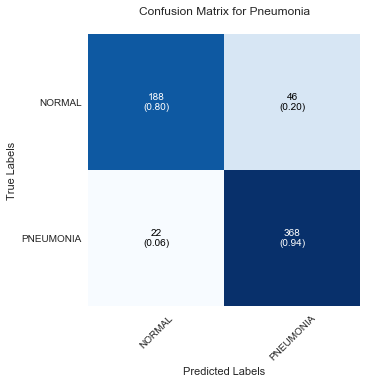

In [14]:
# Create Confusion Matrix
plt.style.use('seaborn')

cm = metrics.confusion_matrix(true_classes,predicted_classes)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5),
                                class_names = class_labels,
                                show_normed = True)
ax.set(title = "Confusion Matrix for Pneumonia",
       ylabel = "True Labels",
       xlabel = "Predicted Labels")
plt.show()

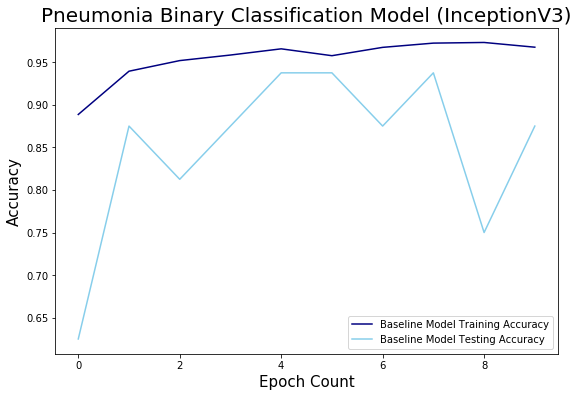

In [20]:
# Plot

train_loss = hist.history["accuracy"]
test_loss = hist.history["val_accuracy"]
plt.figure(figsize = (9,6))


plt.plot(train_loss, label = "InceptionV3 Model Training Accuracy", color = "navy")
plt.plot(test_loss, label = "InceptionV3 Model Testing Accuracy" , color= "skyblue")
plt.title("Pneumonia Binary Classification", fontsize = 20)
plt.xlabel("Epoch Count", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend();

Correction: In the graph above, the light blue line is labelled as Baseline Testing Accuracy it is actually the validation accuracy. 

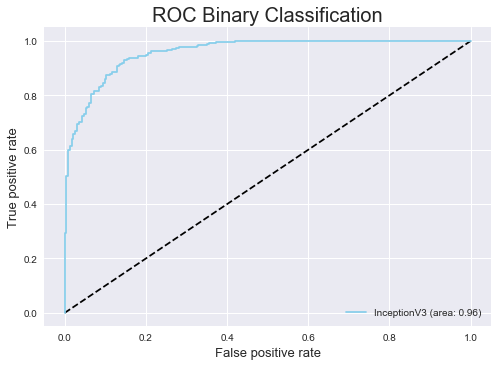

In [16]:
# ROC curve graph for InceptionV3

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(true_classes, pred)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='InceptionV3 (area: %0.2f)'
             % auc(fpr,tpr), color = "skyblue")
plt.xlabel('False positive rate', fontsize = 13)
plt.ylabel('True positive rate', fontsize = 13)
plt.title('ROC Binary Classification', fontsize = 20)
plt.legend(loc='best')
plt.show()

In [23]:
# save weights from this model
model.save_weights("../output/inception_model.h5")